Dentro de vs_release_16k.zip descomprimimos dos carpetas:  
- audio_16k  
- meta  

Nos servimos del módulo zipfile para descomprimir y adicionalmente del módulo concurrent para utilizar threads agilizando la descompresión.  
https://superfastpython.com/multithreaded-unzip-files/#Unzip_Files_Concurrently_with_Processes

In [1]:
import os
from zipfile import ZipFile
from concurrent.futures import ThreadPoolExecutor

def unzip_file(handle, filename, path):
    handle.extract(path=path, member=filename)

output_dir = "data"
zip_filename = "vs_release_16k.zip"
dirs_to_extract = ["audio_16k", "meta"]

if not os.path.exists(output_dir):
    try:
        with ZipFile(zip_filename, 'r') as zf:
            filenames = zf.namelist()

            files_to_extract = [
                file for file in filenames
                if any(file.startswith(dir) for dir in dirs_to_extract)
            ]

            with ThreadPoolExecutor() as exe:
                for file in files_to_extract:
                    exe.submit(unzip_file, zf, file, output_dir)
    except:
        raise FileNotFoundError

print(os.listdir(output_dir))

['audio_16k', 'meta']


Ahora pasamos los datos a numpy arrays para poder trabajar con ellos:

In [2]:
import os
import wave
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor

def read_wav_file(wav_file):
    with wave.open(wav_file, 'rb') as wf:
        num_frames = wf.getnframes()
        frames = wf.readframes(num_frames)
        wave_array = np.frombuffer(frames, dtype=np.int16)
        wave_name = os.path.basename(wav_file)
        wave_name = os.path.splitext(wave_name)[0]
    return wave_name, wave_array

base_dir = "data"
dir = "audio_16k"

audio_dir = os.path.join(base_dir, dir)
audios = os.listdir(audio_dir)
audio_paths = [os.path.join(audio_dir, file) for file in audios]

with ThreadPoolExecutor() as exe:
    results = list(exe.map(read_wav_file, audio_paths))

results[0:5]

[('f0003_0_cough', array([38, 53, 50, ..., 19, 16,  9], dtype=int16)),
 ('f0003_0_laughter', array([-29,  71, 161, ..., 769, 860, 898], dtype=int16)),
 ('f0003_0_sigh', array([15, 49, 19, ..., 10, 10, 15], dtype=int16)),
 ('f0003_0_sneeze', array([ 49,  16, -69, ...,  -4,   1,   6], dtype=int16)),
 ('f0003_0_sniff', array([-37, -64, -58, ...,  21,  26,  24], dtype=int16))]

In [3]:
import os
import wave
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor

def read_wav_file(wav_file):
    with wave.open(wav_file, 'rb') as wf:
        num_frames = wf.getnframes()
        frames = wf.readframes(num_frames)
        wave_array = np.frombuffer(frames, dtype=np.int16)
        wave_name = os.path.basename(wav_file)
        wave_name = os.path.splitext(wave_name)[0]
    return wave_name, wave_array

base_dir = "data"
dir = "audio_16k"

audio_dir = os.path.join(base_dir, dir)
audios = os.listdir(audio_dir)
audio_paths = [os.path.join(audio_dir, file) for file in audios]

with ThreadPoolExecutor() as exe:
    results = list(exe.map(read_wav_file, audio_paths))

results[0:5]

[('f0003_0_cough', array([38, 53, 50, ..., 19, 16,  9], dtype=int16)),
 ('f0003_0_laughter', array([-29,  71, 161, ..., 769, 860, 898], dtype=int16)),
 ('f0003_0_sigh', array([15, 49, 19, ..., 10, 10, 15], dtype=int16)),
 ('f0003_0_sneeze', array([ 49,  16, -69, ...,  -4,   1,   6], dtype=int16)),
 ('f0003_0_sniff', array([-37, -64, -58, ...,  21,  26,  24], dtype=int16))]

Observación: Nuestros threadings acceden a elementos distintos por tanto no hay problemas de race condition.

f0003_0_cough.wav  
f -> female  
(o -> old? check transcripted)  
cough -> one of the 6 labels  
0 -> index of that cough (individuals may have more than 1 cough registered)

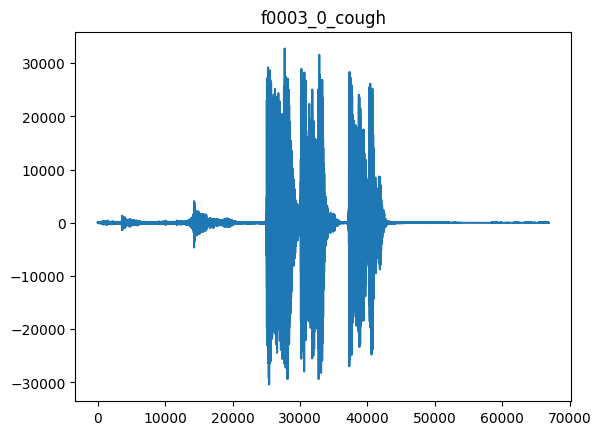

In [4]:
import matplotlib.pyplot as plt
name, arr = results[0]
plt.plot(arr)
plt.title(name)
plt.show()

In [9]:
import pandas as pd
import numpy as np

# Extraer información de cada registro
def extraer_informacion(registro):
    id_y_clase = registro[0].split('_')
    id = id_y_clase[0][1:]  # Eliminar el primer carácter y tomar el resto como ID
    sex = 'female' if id_y_clase[0][0] == 'f' else ('male' if id_y_clase[0][0] == 'm' else 'other')
    clase = id_y_clase[-1]  # La clase es el último elemento después de dividir por '_'
    return id, sex, clase, registro[1]

# Crear una lista de diccionarios para cada registro
datos_procesados = [{
    "id": extraer_informacion(registro)[0],
    "sex": extraer_informacion(registro)[1],
    "class": extraer_informacion(registro)[2],
    "data": extraer_informacion(registro)[3]
} for registro in results]

# Crear el DataFrame de Pandas
df = pd.DataFrame(datos_procesados)
# Añadir la columna 'index' que simplemente es el índice del DataFrame
df.reset_index(inplace=True)
df

,index,id,sex,class,data
0,0,0003,female,cough,"[38, 53, 50, 49, -6, -15, -26, -32, -6, -1, 36..."
1,1,0003,female,laughter,"[-29, 71, 161, 211, 192, 49, -13, -173, -207, ..."
2,2,0003,female,sigh,"[15, 49, 19, 22, -14, -19, 13, -13, 24, 12, 24..."
3,3,0003,female,sneeze,"[49, 16, -69, 146, -76, 132, -22, 86, 66, 6, 6..."
4,4,0003,female,sniff,"[-37, -64, -58, -72, -70, -68, -66, -70, -68, ..."
...,...,...,...,...,...
21019,21019,3362,other,laughter,"[41, 164, 17, 111, 44, -48, -50, 49, 27, -111,..."
21020,21020,3362,other,sigh,"[-1, -2, -2, -1, 0, -1, -1, -2, -1, -2, -1, 0,..."
21021,21021,3362,other,sneeze,"[909, 3041, 3134, 2094, -591, -1005, -1713, -6..."
21022,21022,3362,other,sniff,"[12, -233, -60, -95, -65, 180, -86, -94, -101,..."


Vamos a realizar un análisis de las señales de audio utilizando la transformada de Fourier. la transformada de Fourier es una técnica matemática utilizada para descomponer una señal en sus componentes de frecuencia, revelando así la cantidad de cada frecuencia presente en la señal. Convierte una señal del dominio del tiempo (por ejemplo, una onda de sonido) en el dominio de la frecuencia, mostrando las diferentes frecuencias que componen esa señal. 

Utilizando esta transformada calcularemos el espectro de frecuencia promedio de nuestros diferentes tipos de sonidos. Lo que nos permite visualizar cómo varía la amplitud de las diferentes frecuencias en cada tipo de sonido. Este análisis nos ayuda a identificar las características espectrales distintivas de cada tipo de sonido, lo que va a ser útil para saber la frecuencia en la que nos movemos en cada sonido para su posterior filtrado.


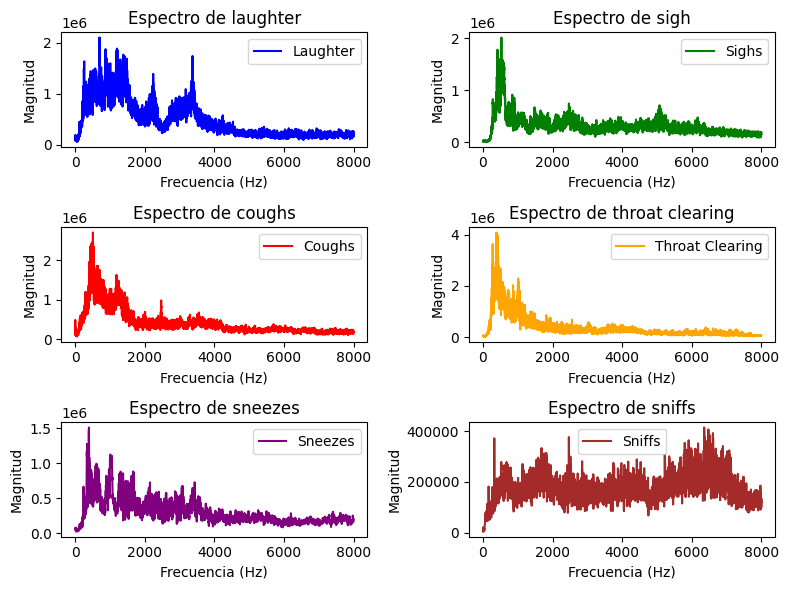

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft


# Función para calcular el espectro de frecuencia promedio
def calcular_espectro_promedio(signals, sample_rate):
    # Encontrar la longitud mínima de las señales
    min_length = min(len(signal) for signal in signals)
    
    # Recortar todas las señales a la longitud mínima
    signals = [signal[:min_length] for signal in signals]
    
    spectra = []
    for signal in signals:
        fft_result = fft(signal)
        frequencies = np.fft.fftfreq(min_length, 1 / sample_rate)
        spectrum = np.abs(fft_result)[:min_length//2]
        spectra.append(spectrum)
    return np.mean(spectra, axis=0), frequencies  # Frequencies sin recortar

sample_rate = 16000 #dado por la base de datos


# Función para visualizar el espectro de frecuencia promedio
def visualizar_espectro_promedio(spectrum, frequencies, label):
    plt.plot(frequencies, spectrum, label=label)

# Función para encontrar los límites del rango de frecuencias relevantes
def encontrar_limites_frecuencias(frequencies, spectrum, threshold):
    start_index = 0
    end_index = len(frequencies) - 1
    for i, value in enumerate(spectrum):
        if value >= threshold:
            start_index = i
            break
    for i in range(len(frequencies) - 1, -1, -1):
        if spectrum[i] >= threshold:
            end_index = i
            break
    return frequencies[start_index], frequencies[end_index]

# Tomar todas las muestras de audio
signals = [np.array(signal) for signal in df['data']]

# Calcular el espectro de frecuencia promedio para cada tipo de sonido
spectrum_laughter, frequencies = calcular_espectro_promedio(signals_laughter, sample_rate)
spectrum_sighs, _ = calcular_espectro_promedio(signals_sighs, sample_rate)
spectrum_coughs, _ = calcular_espectro_promedio(signals_coughs, sample_rate)
spectrum_throat_clearing, _ = calcular_espectro_promedio(signals_throat_clearing, sample_rate)
spectrum_sneezes, _ = calcular_espectro_promedio(signals_sneezes, sample_rate)
spectrum_sniffs, _ = calcular_espectro_promedio(signals_sniffs, sample_rate)

# Calcular las frecuencias positivas para cada tipo de sonido individualmente
half_length = len(spectrum_laughter) // 2  # Longitud de la mitad del espectro
frequencies_positive = np.fft.fftfreq(len(spectrum_laughter), 1 / sample_rate)[:half_length]

# Tomar solo la parte positiva de los espectros de frecuencia
spectrum_positive_laughter = spectrum_laughter[:half_length]
spectrum_positive_sighs = spectrum_sighs[:half_length]
spectrum_positive_coughs = spectrum_coughs[:half_length]
spectrum_positive_throat_clearing = spectrum_throat_clearing[:half_length]
spectrum_positive_sneezes = spectrum_sneezes[:half_length]
spectrum_positive_sniffs = spectrum_sniffs[:half_length]

# Visualizar los espectros de frecuencia promedio por separado
plt.figure(figsize=(8, 6))

# Espectro de risas
plt.subplot(321)
plt.plot(frequencies_positive, spectrum_positive_laughter, label='Laughter', color='blue')
plt.title('Espectro de laughter')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.legend()

# Espectro de suspiros
plt.subplot(322)
plt.plot(frequencies_positive, spectrum_positive_sighs, label='Sighs', color='green')
plt.title('Espectro de sigh')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.legend()

# Espectro de tos
plt.subplot(323)
plt.plot(frequencies_positive, spectrum_positive_coughs, label='Coughs', color='red')
plt.title('Espectro de coughs')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.legend()

# Espectro de aclarar la garganta
plt.subplot(324)
plt.plot(frequencies_positive, spectrum_positive_throat_clearing, label='Throat Clearing', color='orange')
plt.title('Espectro de throat clearing')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.legend()

# Espectro de estornudos
plt.subplot(325)
plt.plot(frequencies_positive, spectrum_positive_sneezes, label='Sneezes', color='purple')
plt.title('Espectro de sneezes')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.legend()

# Espectro de aspiraciones nasales
plt.subplot(326)
plt.plot(frequencies_positive, spectrum_positive_sniffs, label='Sniffs', color='brown')
plt.title('Espectro de sniffs')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.legend()

plt.tight_layout()
plt.show()





A continuación, tomaremos un rango de frecuencia basandonos en el espectograma para cada caso. Un espectrograma,  es una representación visual de cómo varía la energía de la señal en función del tiempo y la frecuencia,  buscaremos los picos de amplitud para identificar las frecuencias dominantes en un determinado período de tiempo. 

Después aplicaremos un filtro pasa banda Butterworth en el dominio del tiempo, esto implica diseñar un filtro para atenuar o eliminar las frecuencias no deseadas y mantener las frecuencias de interés. Al aplicar este filtro a la señal de audio, se obtiene una versión filtrada que resalta nuestros componentes acústicos relevantes, encontrando picos de frecuencia asociados con los eventos de interés, como la tos o la risa. Este proceso mejora la calidad de la señal al eliminar el ruido y otras interferencias, lo que facilita su identificación. Mejorando así el rendimiento del modelo, conduciendo a predicciones más precisas.

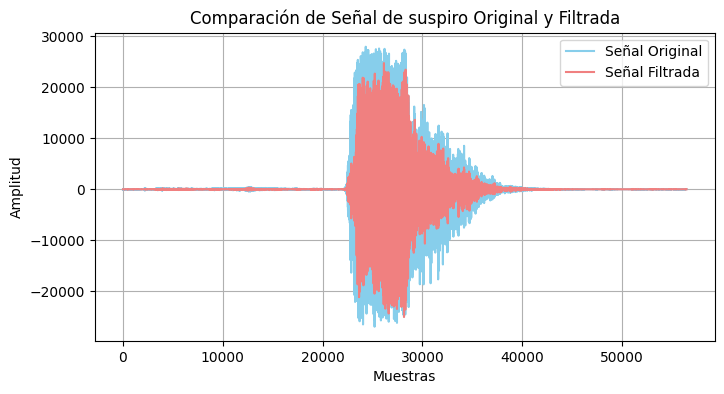

    index    id class                                               data
2       2  0003  sigh  [0.0019170846266632758, 0.00963063249216162, 0...
8       8  0004  sigh  [0.006390282088877586, 0.02698988263610333, 0....
14     14  0007  sigh  [0.10863479551091895, 0.6805707932978088, 1.62...
20     20  0008  sigh  [-0.0006390282088877586, -0.003849239039608298...
26     26  0010  sigh  [0.0006390282088877586, 0.005766323666271574, ...


In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter  # Importar lfilter


# Función para filtrar la señal en el dominio del tiempo
def filtrar_señal(signal, sample_rate, frecuencias_interes):
    # Filtro pasa banda Butterworth
    nyquist = 0.5 * sample_rate
    normal_frequencies = [f / nyquist for f in frecuencias_interes]
    b, a = butter(N=4, Wn=normal_frequencies, btype='bandpass')
    # Aplicar el filtro
    signal_filtrada = lfilter(b, a, signal)  # Utilizar lfilter
    return signal_filtrada

# Frecuencias relevantes asociadas con el sonido de los suspiros
frecuencias_suspiro = [100, 1000]

# Filtrar todas las señales identificadas como suspiros en el DataFrame
signals_suspiro_filtradas = []

for index, row in df[df['class'] == 'sigh'].iterrows():
    signal = row['data']
    signal_suspiro_filtrada = filtrar_señal(signal, sample_rate, frecuencias_suspiro)
    signals_suspiro_filtradas.append(signal_suspiro_filtrada)

# Convertir la lista de señales filtradas en un DataFrame de Pandas
df_suspiro_filtrada = pd.DataFrame({'data': signals_suspiro_filtradas})

# Crear un nuevo DataFrame con las señales filtradas de suspiros
df_suspiro_filtrado = df[df['class'] == 'sigh'].copy()  # Filtrar solo las señales de suspiros
df_suspiro_filtrado['data'] = df_suspiro_filtrada['data']  # Reemplazar los datos con las señales filtradas

# Eliminar la columna 'sex' 
df_suspiro_filtrado.drop(columns=['sex'], inplace=True)

# Obtener la primera señal original y su versión filtrada
signal_original = df[df['class'] == 'sigh']['data'].iloc[0]
signal_filtrada = df_suspiro_filtrada.iloc[0]['data']

# Graficar la primera señal original y su versión filtrada superpuestas
plt.figure(figsize=(8, 4))

# Graficar la señal original
plt.plot(signal_original, label='Señal Original', color='skyblue')

# Graficar la señal filtrada
plt.plot(signal_filtrada, label='Señal Filtrada', color='lightcoral')

plt.title('Comparación de Señal de suspiro Original y Filtrada')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()

# Mostrar las primeras filas del nuevo DataFrame
print(df_suspiro_filtrado.head())


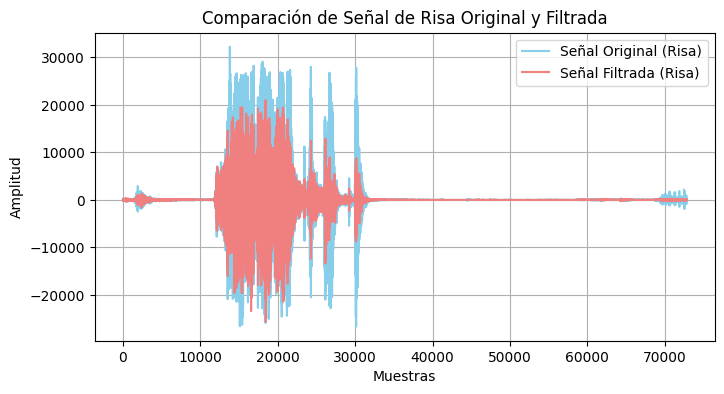

    index    id     class                                               data
1       1  0003  laughter  [0.0, 0.0, 0.0, 0.0, 0.0, -0.01020948079120313...
7       7  0004  laughter  [0.3573318276921097, 2.65325304021869, 1.03702...
13     13  0007  laughter  [-1.5722600418452826, -7.427169367821733, -11....
19     19  0008  laughter  [0.010209480791203134, 0.04663728460281077, 0....
25     25  0010  laughter  [0.30628442373609405, 1.5012133459963546, 2.17...


In [135]:
# Frecuencias relevantes asociadas con el sonido de las risas
frecuencias_risa = [1000, 3000]

# Filtrar todas las señales identificadas como risas en el DataFrame
signals_risa_filtradas = []

for index, row in df[df['class'] == 'laughter'].iterrows():
    signal = row['data']
    signal_risa_filtrada = filtrar_señal(signal, sample_rate, frecuencias_risa)
    signals_risa_filtradas.append(signal_risa_filtrada)

# Convertir la lista de señales filtradas en un DataFrame de Pandas
df_risa_filtrada = pd.DataFrame({'data': signals_risa_filtradas})

# Crear un nuevo DataFrame con las señales filtradas de risas
df_risa_filtrado = df[df['class'] == 'laughter'].copy()  # Filtrar solo las señales de risas
df_risa_filtrado['data'] = df_risa_filtrada['data']  # Reemplazar los datos con las señales filtradas

# Eliminar la columna 'sex'
df_risa_filtrado.drop(columns=['sex'], inplace=True)

# Obtener la primera señal original y su versión filtrada
signal_original_risa = df[df['class'] == 'laughter']['data'].iloc[0]
signal_filtrada_risa = df_risa_filtrada.iloc[0]['data']

# Graficar la primera señal original y su versión filtrada superpuestas
plt.figure(figsize=(8, 4))

# Graficar la señal original de risa
plt.plot(signal_original_risa, label='Señal Original (Risa)', color='skyblue')

# Graficar la señal filtrada de risa
plt.plot(signal_filtrada_risa, label='Señal Filtrada (Risa)', color='lightcoral')

plt.title('Comparación de Señal de Risa Original y Filtrada')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()

# Mostrar las primeras filas del nuevo DataFrame de risas filtradas
print(df_risa_filtrado.head())


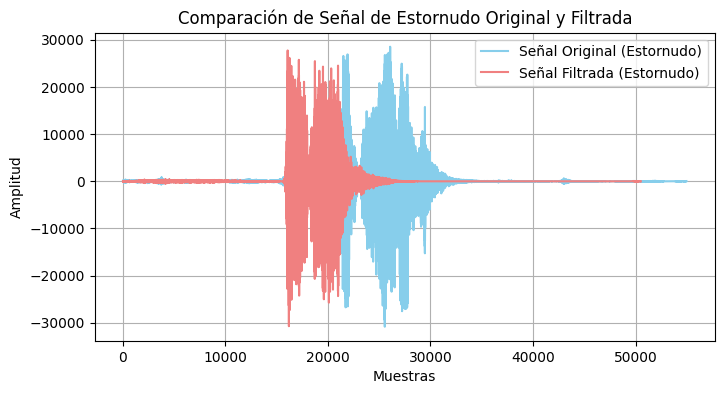

    index    id   class                                               data
3       3  0003  sneeze  [13.721204309333983, 51.0371023215543, 44.4760...
9       9  0004  sneeze  [54.32093212873317, 198.79256213630492, 177.24...
15     15  0007  sneeze  [-19.82995965253062, -75.63292361898448, -75.4...
21     21  0008  sneeze  [0.0, 0.2819425543013832, 0.9862682491478414, ...
27     27  0010  sneeze  [0.0, 0.09398085143379441, 0.39140998400514343...


In [153]:
# Frecuencias relevantes asociadas con el sonido de los estornudos
frecuencias_estornudo = [1000, 5000]

# Filtrar todas las señales identificadas como estornudos en el DataFrame
signals_estornudo_filtradas = []

for index, row in df[df['class'] == 'sneeze'].iterrows():
    signal = row['data']
    signal_estornudo_filtrada = filtrar_señal(signal, sample_rate, frecuencias_estornudo)
    signals_estornudo_filtradas.append(signal_estornudo_filtrada)

# Convertir la lista de señales filtradas en un DataFrame de Pandas
df_estornudo_filtrada = pd.DataFrame({'data': signals_estornudo_filtradas})

# Crear un nuevo DataFrame con las señales filtradas de estornudos
df_estornudo_filtrado = df[df['class'] == 'sneeze'].copy()  # Filtrar solo las señales de estornudos
df_estornudo_filtrado['data'] = df_estornudo_filtrada['data']  # Reemplazar los datos con las señales filtradas

# Eliminar la columna 'sex'
df_estornudo_filtrado.drop(columns=['sex'], inplace=True)

# Obtener la primera señal original y su versión filtrada
signal_original_estornudo = df[df['class'] == 'sneeze']['data'].iloc[0]
signal_filtrada_estornudo = df_estornudo_filtrado.iloc[0]['data']

# Graficar la primera señal original y su versión filtrada superpuestas
plt.figure(figsize=(8, 4))

# Graficar la señal original de estornudo
plt.plot(signal_original_estornudo, label='Señal Original (Estornudo)', color='skyblue')

# Graficar la señal filtrada de estornudo
plt.plot(signal_filtrada_estornudo, label='Señal Filtrada (Estornudo)', color='lightcoral')

plt.title('Comparación de Señal de Estornudo Original y Filtrada')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()

# Mostrar las primeras filas del nuevo DataFrame de estornudos filtradas
print(df_estornudo_filtrado.head())
